In [194]:
# Magic home
%cd /home/benjamin/git/swiss-river-network-benchmark/

import numpy as np
import matplotlib.pyplot as plt

from swissrivernetwork.benchmark.dataset import read_graph

# Define two stations to interpolate:
#station_a = '2152' # Luzern
#station_a = '2135' # Bern
#station_a = '2085' # Hagneck
#station_b = '2030' # Thun?
#station_c = '2135' # Bern (interpolation target)

# Interpolate Bern by Thun and Hagneck:
station_c = '2135'
station_a = '2030'
station_b = '2085'

# Interpolate Hagneck by Bern and Laupen
#station_c = '2085'
#station_a = '2467'
#station_b = '2135'

# best is to pick two that have an actual one inbetween (ground truth)
graph_name = ['swiss-1990', 'swiss-2010', 'zurich'][1]
method = ['concatenation_embedding',
        #'concatenation_embedding_output',
        'embedding_gate_memory',
        'embedding_gate_hidden',
        'interpolation_embedding'][3]


/home/benjamin/git/swiss-river-network-benchmark


In [195]:

# read graph and stations
x, e = read_graph(graph_name)

PRINT_STATIONS = False
if PRINT_STATIONS:
    for i,row in enumerate(x):
        print('idx:', i, row)

idx_a = (x[:, 2] == int(station_a)).nonzero().item()
idx_b = (x[:, 2] == int(station_b)).nonzero().item()
idx_c = (x[:, 2] == int(station_c)).nonzero().item()

print('idx a:', idx_a)
print('idx b:', idx_b)


idx a: 44
idx b: 28


RMSE interpolation (alpha=0.00): 1.245
RMSE interpolation (alpha=0.10): 1.126
RMSE interpolation (alpha=0.20): 1.010
RMSE interpolation (alpha=0.30): 0.896
RMSE interpolation (alpha=0.40): 0.787
RMSE interpolation (alpha=0.50): 0.685
RMSE interpolation (alpha=0.60): 0.593
RMSE interpolation (alpha=0.70): 0.517
RMSE interpolation (alpha=0.80): 0.464
RMSE interpolation (alpha=0.90): 0.442
RMSE interpolation (alpha=1.00): 0.457


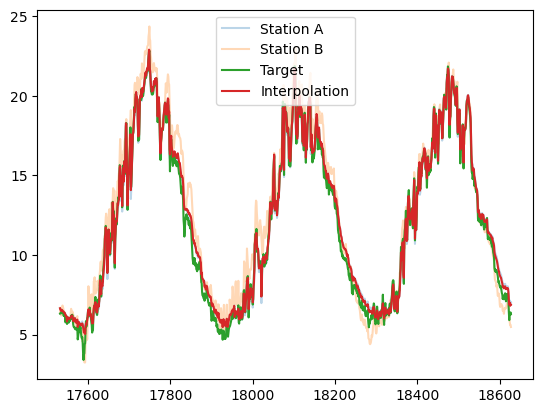

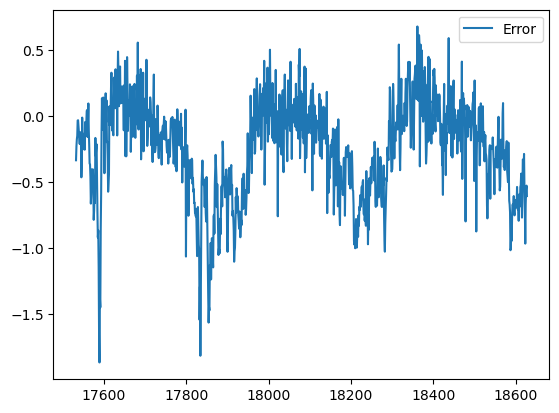

In [196]:
from swissrivernetwork.benchmark.dataset import read_csv_train, read_csv_test, select_isolated_station
from swissrivernetwork.benchmark.test_isolated_station import fit_normalizers
from swissrivernetwork.experiment.error import Error



# Load test data
def load_test_data(station):
    df_train = read_csv_train(graph_name)
    df_train = select_isolated_station(df_train, station)
    normalizer_at, normalizer_wt = fit_normalizers(df_train)

    df = read_csv_test(graph_name)
    df = select_isolated_station(df, station)
    return df, normalizer_at, normalizer_wt

# Visualize Test Data
df_a, norm_at_a, norm_wt_a = load_test_data(station_a)
df_b, norm_at_b, norm_wt_b = load_test_data(station_b)
df_c, norm_at_c, norm_wt_c = load_test_data(station_c) # target station

for alpha in np.linspace(0, 1.0, 11):
    interpolation = alpha * df_a['water_temperature']+ (1-alpha) * df_b['water_temperature'] # predict Bern    
    error_interpolation = df_c['water_temperature'] - interpolation # error of interpolation
    rmse_interpolation = Error.rmse(df_c['water_temperature'], interpolation)
    print(f'RMSE interpolation (alpha={alpha:.2f}): {rmse_interpolation:.3f}')

alpha = 0.9
interpolation = alpha * df_a['water_temperature']+ (1-alpha) * df_b['water_temperature'] # predict Bern
error_interpolation = df_c['water_temperature'] - interpolation # error of interpolation

plt.figure()
plt.plot(df_a['epoch_day'], df_a['water_temperature'], label='Station A', alpha=0.3)
plt.plot(df_b['epoch_day'], df_b['water_temperature'], label='Station B', alpha=0.3)
plt.plot(df_a['epoch_day'], df_c['water_temperature'], label='Target')
plt.plot(df_a['epoch_day'], interpolation, label='Interpolation')
plt.legend()

plt.figure()
plt.plot(df_a['epoch_day'], error_interpolation, label='Error')
plt.legend()
plt.show()


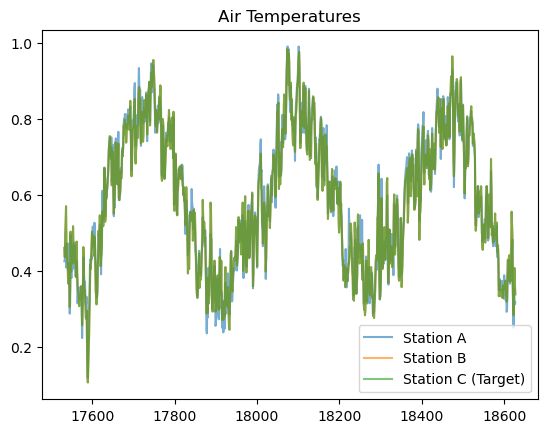

In [197]:
# Preapre Air Temperature

# normalize:
df_a['air_temperature'] = norm_at_a.transform(df_a['air_temperature'].values.reshape(-1, 1))
df_b['air_temperature'] = norm_at_b.transform(df_b['air_temperature'].values.reshape(-1, 1))
df_c['air_temperature'] = norm_at_c.transform(df_c['air_temperature'].values.reshape(-1, 1))


plt.figure()
plt.plot(df_a['epoch_day'], df_a['air_temperature'], label='Station A', alpha=0.6)
plt.plot(df_b['epoch_day'], df_b['air_temperature'], label='Station B', alpha=0.6)
plt.plot(df_c['epoch_day'], df_c['air_temperature'], label='Station C (Target)', alpha=0.6)
plt.title('Air Temperatures')
plt.legend()
plt.show()


In [198]:
# load best model for Stations A, B, C
import os
import torch

from swissrivernetwork.benchmark.test_embedding_model import read_stations
from swissrivernetwork.benchmark.lstm_embedding import EMBEDDING_MODEL_FACTORY
from swissrivernetwork.benchmark.ray_evaluation_embedding import experiment_analysis_single_model, experiment_analysis_static_embedding, experiment_analysis_lowd

#analysis = experiment_analysis_single_model(graph_name, method)
#analysis = experiment_analysis_lowd(graph_name, method)
analysis = experiment_analysis_static_embedding(graph_name, method)
        
best_trial = analysis.get_best_trial(metric="validation_mse", mode="min", scope="all")    
best_config = best_trial.config
    
# Get the best checkpoint
best_checkpoint = analysis.get_best_checkpoint(best_trial, metric="validation_mse", mode="min")    
    
# Create Model:     
num_embeddings = len(read_stations(graph_name))
model_factory = EMBEDDING_MODEL_FACTORY[method]
model = model_factory(1, num_embeddings, best_config['embedding_size'], best_config['hidden_size'])

model_file = sorted(os.listdir(best_checkpoint.path))[0]
model.load_state_dict(torch.load(f'{best_checkpoint.path}/{model_file}'))    
model.eval()

print(best_config)
print(model)
print('embedding a:', )

# Prepare Air Temperature:
#df['air_temperature'] = normalizer_at.transform(df['air_temperature'].values.reshape(-1, 1))

{'batch_size': 64, 'window_len': 90, 'train_split': 0.8, 'learning_rate': 0.005804242297514641, 'epochs': 15, 'embedding_size': 3, 'hidden_size': 125, 'graph_name': 'swiss-2010', 'method': 'interpolation_embedding', 'static_embedding': True}
InterpolationEmbeddingModel(
  (embedding): Embedding(63, 3)
  (lstm): EmbeddingCellLSTM(
    (cell): InterpolationLstmCell()
  )
  (linear): Linear(in_features=125, out_features=1, bias=True)
)
embedding a:


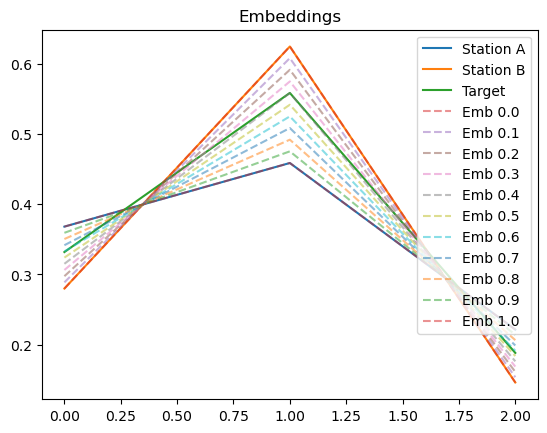

alpha: 0.0: RMSE: 1.314
alpha: 0.1: RMSE: 1.459
alpha: 0.2: RMSE: 1.540
alpha: 0.3: RMSE: 1.344
alpha: 0.4: RMSE: 0.874
alpha: 0.5: RMSE: 0.842
alpha: 0.6: RMSE: 1.537
alpha: 0.7: RMSE: 1.468
alpha: 0.8: RMSE: 1.151
alpha: 0.9: RMSE: 1.301
alpha: 1.0: RMSE: 1.392


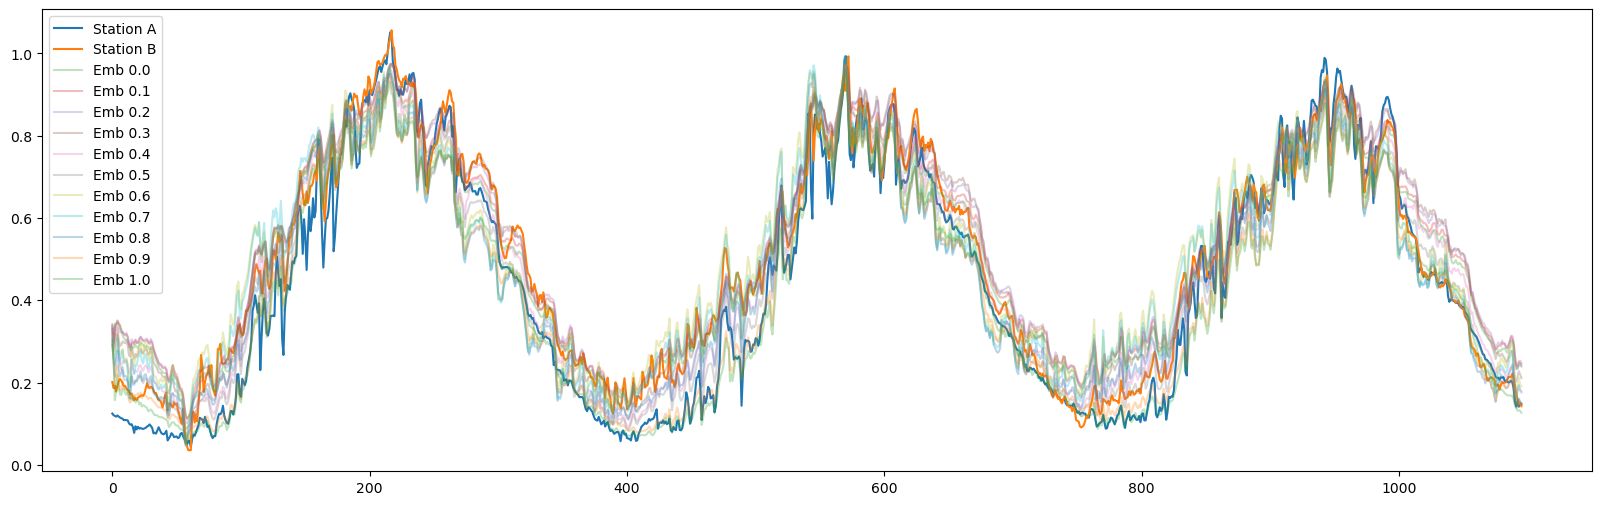

In [199]:
int_tensor = lambda x: torch.tensor(x, dtype=torch.int)
float_tensor = lambda x: torch.tensor(x, dtype=torch.float32)
    

# Invoke the model:
embeddings = model.embedding

def read_emb(idx):
    idx = int_tensor(idx)
    return embeddings(idx).detach().numpy()


emb_a = read_emb(idx_a)
emb_b = read_emb(idx_b)
emb_c = read_emb(idx_c)

rng = range(emb_a.shape[0])
plt.figure()
plt.plot(rng, emb_a, label='Station A')
plt.plot(rng, emb_b, label='Station B')
plt.plot(rng, emb_c, label='Target')
plt.title('Embeddings')

x_a = torch.tensor(df_a['air_temperature'].values, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
x_b = torch.tensor(df_b['air_temperature'].values, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
x_c = torch.tensor(df_c['air_temperature'].values, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)

# Run some embeddings:
alphas = []
xs = []
embs = []
for alpha in np.linspace(0, 1, 11):
    x = alpha*x_a + (1-alpha)*x_b
    #x = x_a
    emb = alpha*emb_a + (1-alpha)*emb_b
    emb = torch.tensor(emb, dtype=torch.float32)    
    plt.plot(rng, emb, '--', label=f'Emb {alpha:.1f}', alpha=0.5)
    emb = emb.repeat((1, x.size(1), 1))
    alphas.append(alpha)
    xs.append(x)
    embs.append(emb)
#print(emb_a)

plt.legend()
plt.show()

# plt.
plt.figure(figsize=(20, 6))

# gt (real, not predicted)
n = len(df_a['epoch_day'])
plt.plot(range(n), norm_wt_a.transform(df_a['water_temperature'].values.reshape(-1, 1)), label='Station A')
plt.plot(range(n), norm_wt_b.transform(df_b['water_temperature'].values.reshape(-1, 1)), label='Station B')

# Invoke Model:
for alpha, x, emb in zip(alphas, xs, embs):
    wt_hat = model(None, x, emb=emb).squeeze(-1).squeeze(0).detach().numpy()    
    plt.plot(range(x.shape[1]), wt_hat, label=f'Emb {alpha:.1f}', alpha = 0.3)
    wt_hat_inv = norm_wt_c.inverse_transform(wt_hat.reshape(-1, 1)).squeeze(-1)
    error_a = Error.rmse(df_c['water_temperature'].values, wt_hat_inv)
    print(f'alpha: {alpha:.1f}: RMSE: {error_a:.3f}')
    



plt.legend()
plt.show()

In [200]:
# Evaluate Interpolatability:
# T = t*A + (1-t)*B

def interpolatability(A, B, T):
    v = B-A
    w = T-A
    if (np.allclose(v, 0)): # degenerated case (B=A)        
        return np.linalg.norm(T-A) # interpolatable if T=A
    t = np.dot(w, v) / np.dot(v, v)
    T_proj = A+t*v
    return np.linalg.norm(T-T_proj) / np.linalg.norm(B-A) # normalize by distance of A to B in this respective embedding space

def interpolate_projection(A, B, T):
    v = B-A
    w = T-A
    if (np.allclose(v, 0)): # degenerated case (B=A)        
        return None # interpolatable if T=A
    t = np.dot(w, v) / np.dot(v, v)
    T_proj = A+t*v
    return T_proj # the projection of T on the Line(A,B)

# test with actual values:
print(emb_a)
print(emb_c)
print(interpolate_projection(emb_a, emb_b, emb_c))
print(emb_b)
value = interpolatability(emb_a, emb_b, emb_c)
print('distance:', value)

[0.36801904 0.45861235 0.22142112]
[0.33181313 0.55838144 0.18823771]
[0.32013723 0.54868066 0.18054046]
[0.27983108 0.6244988  0.14612778]
distance: 0.08409203


In [201]:
# Create all Interpolation pairs.
# (per station)
import pandas as pd

def append_line(line):
    with open('/home/benjamin/untitled', 'a') as f:
        f.write(line + '\n')    

# Evaluate Test RMSE:
def evaluate_test_embedding(station, emb):
    df, normalizer_at, normalizer_wt = load_test_data(station)
    df['air_temperature'] = normalizer_at.transform(df['air_temperature'].values.reshape(-1, 1))
    at = torch.tensor(df['air_temperature'].values, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
    emb = float_tensor(emb)
    emb = emb.repeat((1, at.size(1), 1))   
    wt_hat = model(None, at, emb=emb).squeeze(-1).squeeze(0).detach().numpy()
    wt_hat = normalizer_wt.inverse_transform(wt_hat.reshape(-1, 1)).squeeze(-1)
    wt = df['water_temperature'].values
    mask = ~np.isnan(wt)
    rmse = Error.rmse(wt[mask], wt_hat[mask])
    return rmse

stations = read_stations(graph_name)
x, e = read_graph(graph_name)

out_nodes = set(e[0].tolist())
in_nodes = set(e[1].tolist())
both = out_nodes.intersection(in_nodes)

print('interpolatable node ids: ', both)

col_station = []
col_interpolate = []
col_absolute_rmse = []
col_drop_rmse = []

for idx in both:
    parents = e[1][e[0] == idx]
    childs = e[0][e[1] == idx]
    pairs = torch.cartesian_prod(parents, childs)

    emb_target = read_emb(idx)

    interpolates = []
    projection_rmses = []
    drop_rmses = []
    for pair in pairs:
        a, b = pair.tolist()
        emb_a = read_emb(a)
        emb_b = read_emb(b)
        t = interpolatability(emb_a, emb_b, emb_target)
        #print('interpolate on ', a, b, 'for ', idx, '\tresults: ', t)
        interpolates.append(t)

        # Evaluate the projected interpolation embedding:
        emb_proj = interpolate_projection(emb_a, emb_b, emb_target)
        rmse_proj = evaluate_test_embedding(stations[idx], emb_proj)
        rmse_target = evaluate_test_embedding(stations[idx], emb_target)
        rmse_drop = rmse_proj-rmse_target # higher is bader

        projection_rmses.append(rmse_proj)
        drop_rmses.append(rmse_drop)
        #print(f'Interpolation Performance: {stations[idx]}:\toriginal={rmse_target:.3f},\tprojection={rmse_proj:.3f},\tdiff={rmse_proj-rmse_target:.3f}')



    interpolates = np.mean(interpolates)

    col_station.append(stations[idx])
    col_interpolate.append(interpolates)
    col_absolute_rmse.append(np.mean(projection_rmses))
    col_drop_rmse.append(np.mean(drop_rmses))
    
    #print('Process Station ', stations[idx], 'parents: ', parents, 'childs: ', childs, 'pairs', pairs)
    
    

# 
df_interpolation = pd.DataFrame({'station': col_station,
                                 'interpolatability':col_interpolate,
                                 'Projected RMSE': col_absolute_rmse,
                                 'Drop in RMSE':col_drop_rmse})

line = f'Interpolatability: {graph_name}, {method}, \tInterpolateability: {np.mean(col_interpolate):.3f},\tProjected RMSE: {np.mean(col_absolute_rmse):.3f}, Drop in RMSE: {np.mean(col_drop_rmse):.3f}'
append_line(line)
print(line)

df_interpolation





interpolatable node ids:  {1, 2, 3, 4, 6, 7, 10, 12, 16, 17, 28, 37, 38, 39, 44, 45, 50, 52, 57}
Interpolatability: swiss-2010, interpolation_embedding, 	Interpolateability: 0.176,	Projected RMSE: 1.270, Drop in RMSE: 0.331


,station,interpolatability,Projected RMSE,Drop in RMSE
0,2143,0.091657,1.041303,0.234107
1,2016,0.268526,0.978414,0.295281
2,2018,0.210887,1.356259,0.203780
3,2243,0.134414,1.600496,0.580263
4,2044,0.184463,1.290795,0.395263
5,2288,0.224480,1.397770,0.544095
6,2029,0.143475,1.485717,0.475018
7,2152,0.178350,1.888064,0.940663
8,2104,0.093233,1.062156,0.067258
9,2386,0.212140,0.737555,0.002337
